# Exploratory Data Analysis
A first exploration of the datasets created compressing pristine images from various SOTA papers.

## Libraries

In [1]:
import numpy as np
import glob
import os
import sys
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import pandas as pd

## Let's find all the images inside the various folders

In [12]:
if os.path.exists('/nas/public/exchange/JPEG-AI/data/TEST/data_info.csv'):
    # Load the CSV directly
    all_images = pd.read_csv('/nas/public/exchange/JPEG-AI/data/TEST/data_info.csv')
else:
    # Look for all the images inside the directory (avoid binary files)
    all_images = pd.DataFrame([path for path in glob.glob(os.path.join('/nas/public/exchange/JPEG-AI/data/TEST/**/*.*'), recursive=True) if 'ipynb' not in path], columns=['path'])
    # add other useful info
    all_images['dataset'] = all_images['path'].apply(lambda x: x.split('/')[7])
    all_images['compressed'] = all_images['path'].apply(lambda x: True if 'compressed' in x else False)
    all_images['target_bpp'] = all_images['path'].apply(lambda x: x.split('target_bpp_')[1].split('/')[0] if 'target_bpp' in x else None)
    all_images['target_bpp'] = all_images['target_bpp'].apply(lambda x: float(x)/100 if x is not None else None)
    all_images['filename'] = all_images['path'].apply(lambda x: os.path.basename(x))
    content_dict = {'imagenet': 'various', 'celeba': 'faces', 'ffhq': 'faces', 'coco': 'various', 'raise': 'various', 'laion': 'various'}
    all_images['content'] = all_images['dataset'].apply(lambda x: content_dict[x] if 'lsun' not in x else None)
    # Fix LSUN
    for i, r in all_images.loc[all_images['dataset']=='lsun'].iterrows():
        if r['compressed']:
            all_images.loc[i, 'content'] = r['path'].split('/')[10]
        else:
            all_images.loc[i, 'content'] = r['path'].split('/')[9]
    # Let's add info on the single image sizes
    all_images['size'] = all_images['path'].apply(lambda x: Image.open(x).size)
    # Let's save the data into a csv
    all_images.to_csv('/nas/public/exchange/JPEG-AI/data/TEST/data_info.csv', index=False)
all_images

,path,dataset,compressed,target_bpp,filename,content,size
0,/nas/public/exchange/JPEG-AI/data/TEST/lsun/or...,lsun,False,NaN,13700.png,cat,"(256, 256)"
1,/nas/public/exchange/JPEG-AI/data/TEST/lsun/or...,lsun,False,NaN,10175.png,cat,"(256, 256)"
2,/nas/public/exchange/JPEG-AI/data/TEST/lsun/or...,lsun,False,NaN,17311.png,cat,"(256, 256)"
3,/nas/public/exchange/JPEG-AI/data/TEST/lsun/or...,lsun,False,NaN,09090.png,cat,"(256, 256)"
4,/nas/public/exchange/JPEG-AI/data/TEST/lsun/or...,lsun,False,NaN,17172.png,cat,"(256, 256)"
...,...,...,...,...,...,...,...
155053,/nas/public/exchange/JPEG-AI/data/TEST/ffhq/co...,ffhq,True,2.0,50028.png,faces,"(1024, 1024)"
155054,/nas/public/exchange/JPEG-AI/data/TEST/ffhq/co...,ffhq,True,2.0,59029.png,faces,"(1024, 1024)"
155055,/nas/public/exchange/JPEG-AI/data/TEST/ffhq/co...,ffhq,True,2.0,39029.png,faces,"(1024, 1024)"
155056,/nas/public/exchange/JPEG-AI/data/TEST/ffhq/co...,ffhq,True,2.0,33028.png,faces,"(1024, 1024)"


## Let's plot some info about the dataset

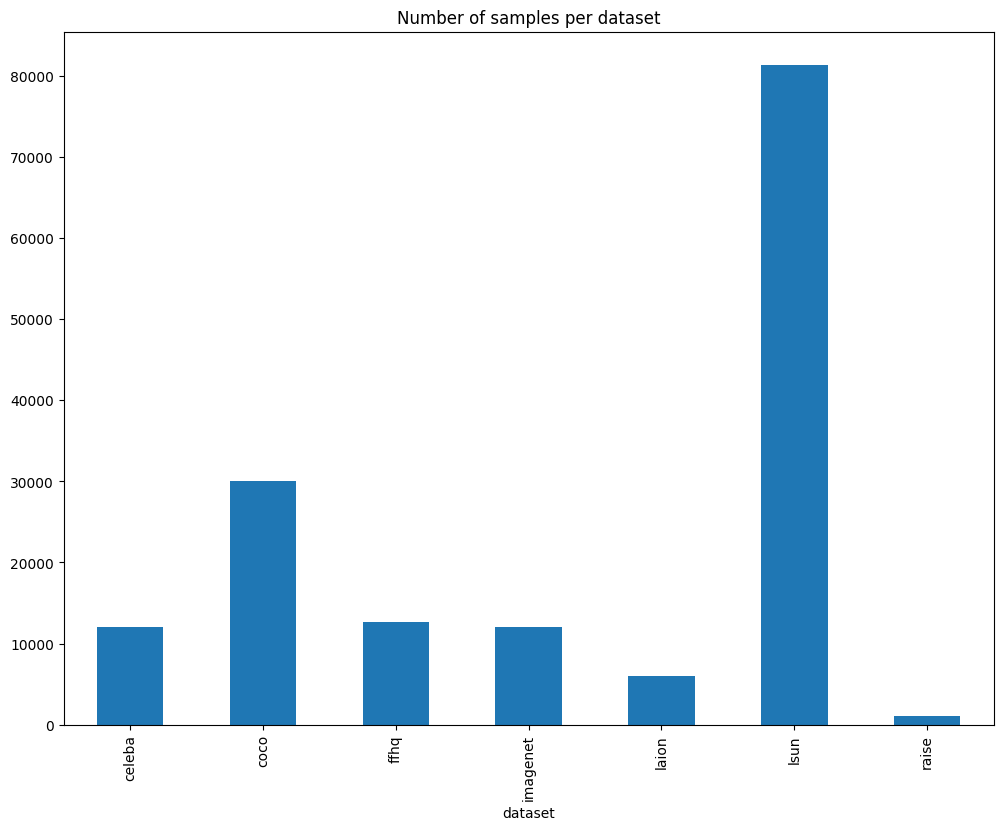

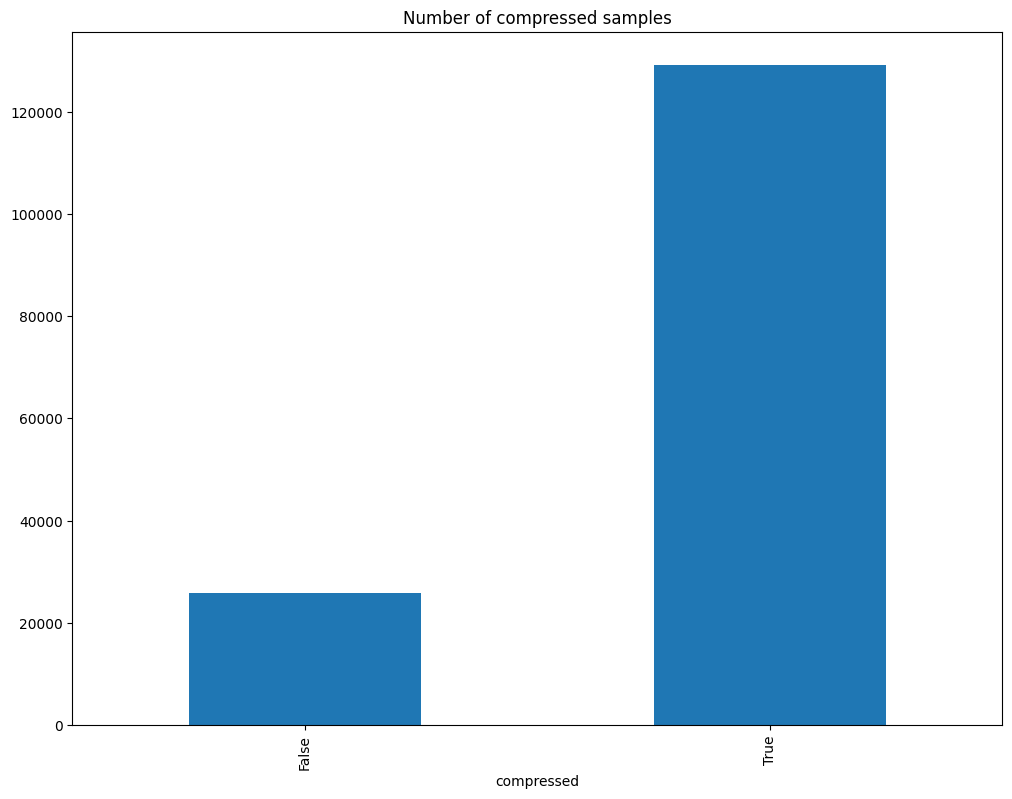

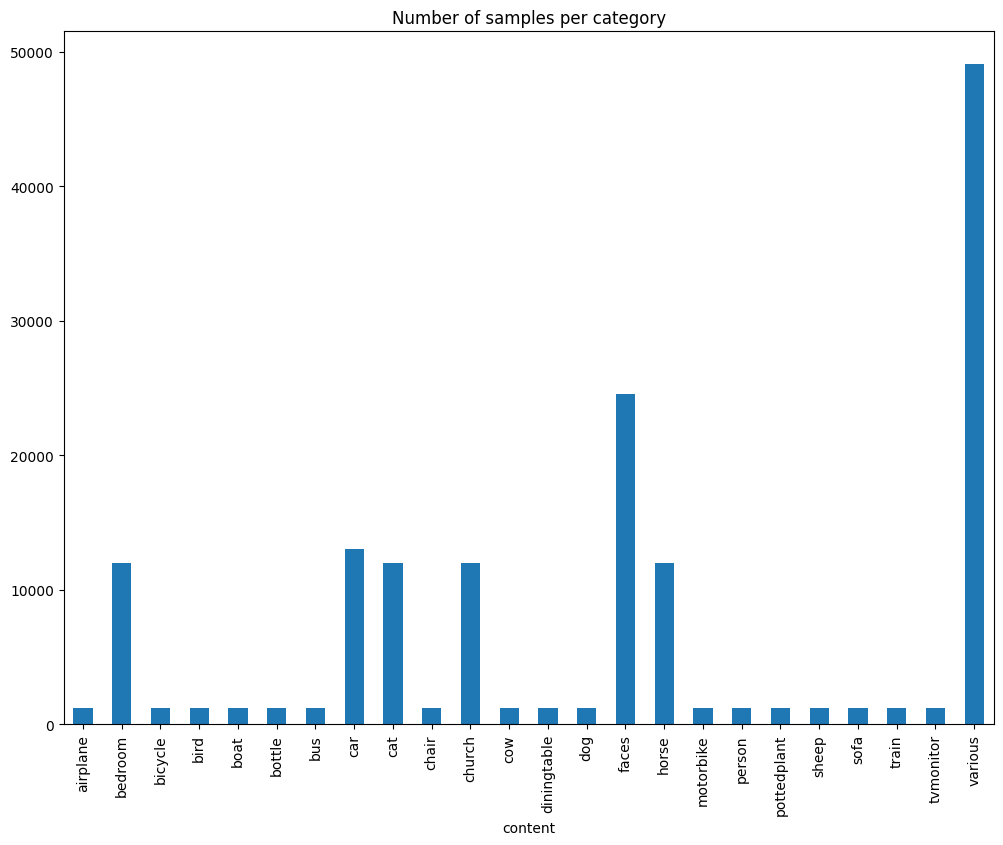

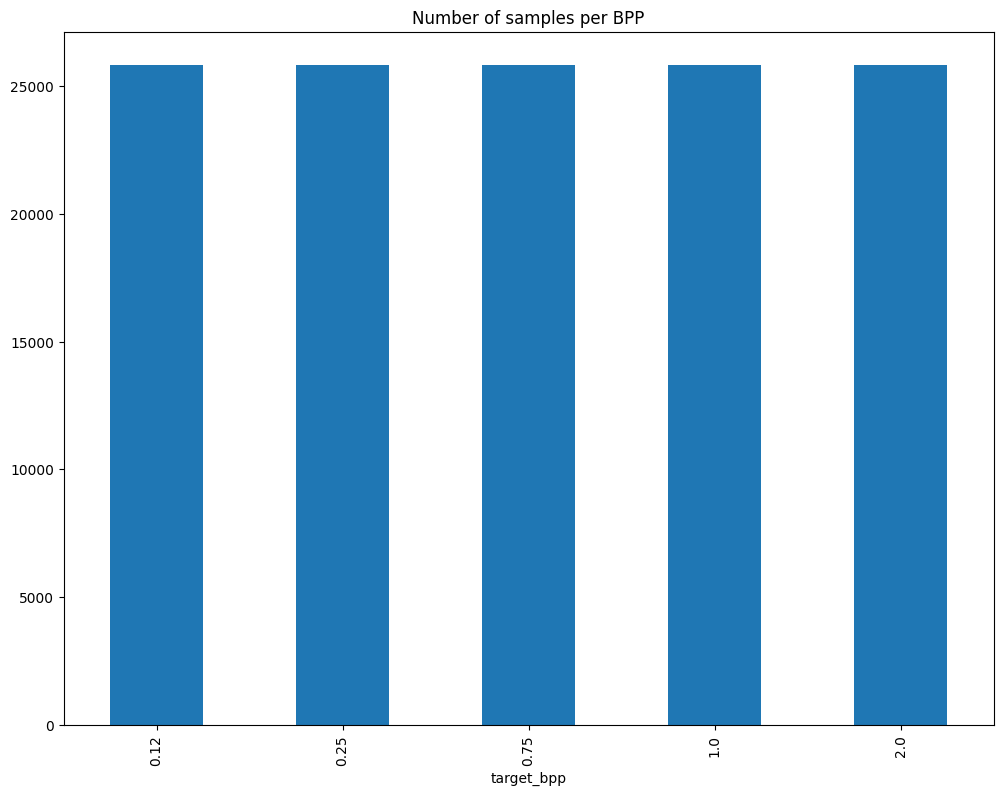

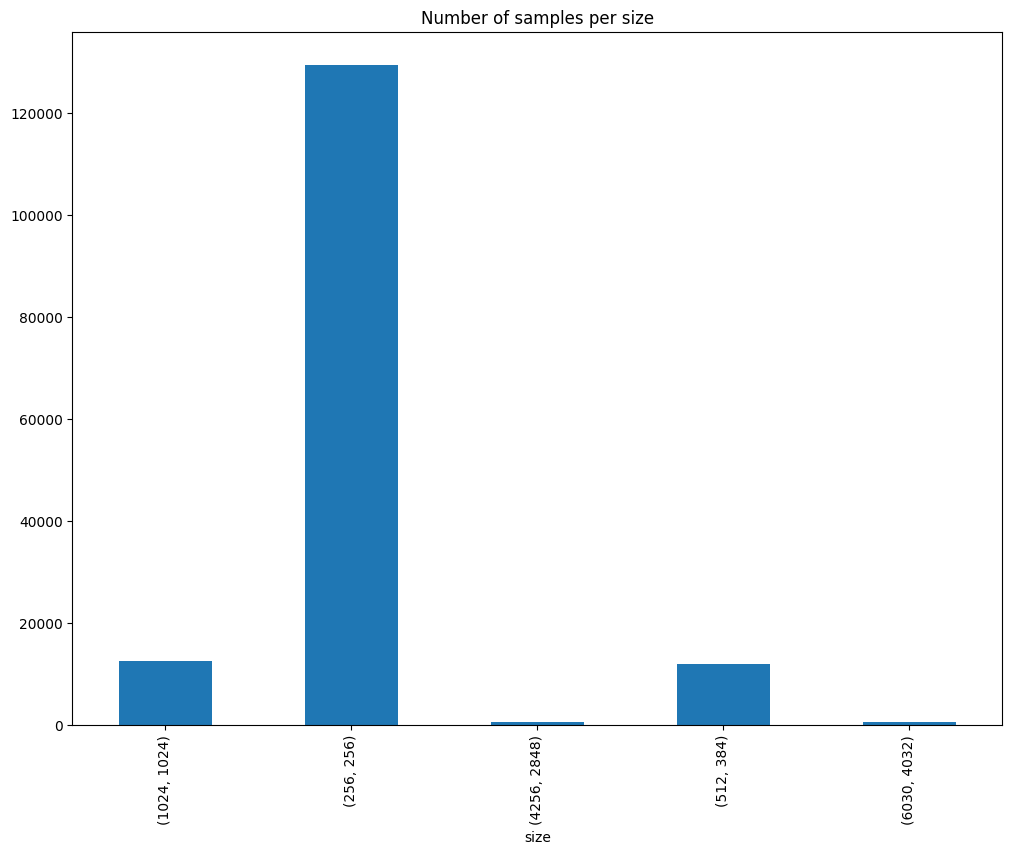

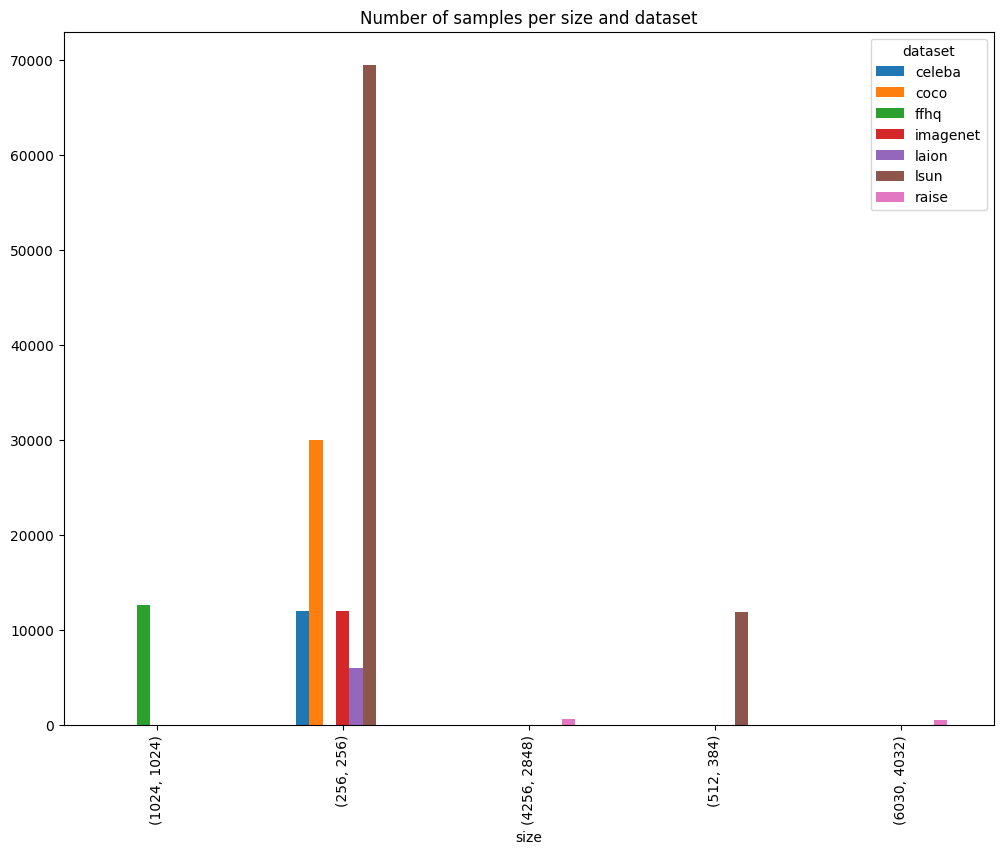

(<Axes: title={'center': 'Number of samples per size and dataset'}, xlabel='size'>,
 Text(0.5, 1.0, 'Number of samples per size and dataset'),
 None)

In [17]:
# Number of samples divided by dataset
all_images.groupby('dataset').count()['path'].plot.bar(figsize=(12, 9)), plt.title('Number of samples per dataset'), plt.show()

# Number of compressed samples
all_images.groupby('compressed').count()['content'].plot.bar(figsize=(12, 9)), plt.title('Number of compressed samples'), plt.show()

# Number of samples divided by semantic category
all_images.groupby('content').count()['path'].plot.bar(figsize=(12, 9)), plt.title('Number of samples per category'), plt.show()

# Number of samples divided by target BPP
all_images.loc[all_images['compressed']].groupby('target_bpp').count()['path'].plot.bar(figsize=(12, 9)), plt.title('Number of samples per BPP'), plt.show()

# Number of samples divided by size
all_images.groupby('size').count()['dataset'].plot.bar(figsize=(12, 9)), plt.title('Number of samples per size'), plt.show()

# Number of samples divided by size and dataset
all_images.groupby(['size', 'dataset']).count()['path'].unstack().plot.bar(figsize=(12, 9)), plt.title('Number of samples per size and dataset'), plt.show()

## Great! Now let's look at some quality metrics

In [14]:
sys.path.append('/nas/home/ecannas/third_party_code/jpeg-ai-reference-software')
from PIL import Image
import torch
from src.codec.metrics.metrics import DataClass, MetricsProcessor, MetricsFabric
from tqdm.notebook import tqdm

In [15]:
# Prepare the metrics processor
metrics = MetricsProcessor()
metrics.internal_bits = 10
metrics.jvet_psnr = False
metrics.metrics = MetricsFabric.metrics_list
metrics.metrics_output = [metric for metric in MetricsFabric.metrics_list]
metrics.color_conv = '709'
metrics.max_samples_for_eval_on_gpu = -1
gpu = 3
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)

In [53]:
dataset_dict = []
for dataset in all_images['dataset'].unique():
    print(f'Doing dataset {dataset}...')
    # select the images from the dataset
    images_df = all_images.loc[all_images['dataset']==dataset]
    orig_df = images_df.loc[~images_df['compressed']].iloc[:5]
    compr_df = images_df.loc[images_df['compressed']]
    
    # Create the metrics Dataframe
    images_dict = []
    
    # Cycle over the different pristine samples
    for i, r in tqdm(orig_df.iterrows()):
        # Load the original sample
        filename, dataset, content = r['filename'], r['dataset'], r['content']
        orig_sample, _ = DataClass().load_image(r['path'], color_conv='709', device='cuda')
        # Find the corresponding compressed samples
        comp_samples = compr_df.loc[(compr_df['filename']==filename.replace('jpg', 'png')) \
                                    & (compr_df['dataset']==dataset) \
                                    & (compr_df['content']==content)]
        # Cycle over the various BPPs values
        bpps_dict = []
        for ii, rr in comp_samples.iterrows():
            # Load the compressed samples
            comp_sample, _ = DataClass().load_image(rr['path'], color_conv='709', device='cuda')
            # Compute the metrics
            metrics_vals = metrics.process_images(orig_sample, comp_sample)
            # Save them
            bpps_dict.append(pd.DataFrame.from_dict({rr['target_bpp']: {metric: metrics_vals[idx] for idx, metric in enumerate(metrics.metrics_output)}},
                                                    orient='index'))
        
        # Append the image path to the Dataframe and save it
        images_dict.append(pd.concat({r['path']: pd.concat(bpps_dict)}, names=['path', 'bpp']))
    
    # Append the images dictionary
    dataset_dict.append(pd.concat({dataset: pd.concat(images_dict)}, names=['dataset', 'path', 'bpp']))

            
        

Doing dataset lsun...


0it [00:00, ?it/s]

/nas/home/ecannas/third_party_code/jpeg-ai-reference-software/src/codec/metrics/IW_SSIM_PyTorch.py:324: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weight = torch.tensor(self.weight).type(self.samplet.type())


Doing dataset imagenet...


0it [00:00, ?it/s]

Doing dataset coco...


0it [00:00, ?it/s]

Doing dataset celeba...


0it [00:00, ?it/s]

Doing dataset raise...


0it [00:00, ?it/s]

Doing dataset laion...


0it [00:00, ?it/s]

Doing dataset ffhq...


0it [00:00, ?it/s]

In [55]:
metrics_info = pd.concat(dataset_dict)
metrics_info

msssim_torch  \
dataset path                                               bpp                  
lsun    /nas/public/exchange/JPEG-AI/data/TEST/lsun/ori... 0.12      0.920199   
                                                           0.25      0.955163   
                                                           0.75      0.991468   
                                                           1.00      0.994954   
                                                           2.00      0.998673   
...                                                                       ...   
ffhq    /nas/public/exchange/JPEG-AI/data/TEST/ffhq/ori... 0.12      0.983523   
                                                           0.25      0.994205   
                                                           0.75      0.998448   
                                                           1.00      0.999198   
                                                           2.00      0.999651   

                                                                 msssim_iqa  \
dataset path                                               bpp                
lsun    /nas/public/exchange/JPEG-AI/data/TEST/lsun/ori... 0.12    0.919654   
                                                           0.25    0.954921   
                                                           0.75    0.991428   
                                                           1.00    0.994935   
                                                           2.00    0.998666   
...                                                                     ...   
ffhq    /nas/public/exchange/JPEG-AI/data/TEST/ffhq/ori... 0.12    0.983398   
                                                           0.25    0.994183   
                                                           0.75    0.998439   
                                                           1.00    0.999190   
                                                           2.00    0.999645   

                                                                      psnr  \
dataset path                                               bpp               
lsun    /nas/public/exchange/JPEG-AI/data/TEST/lsun/ori... 0.12  23.486922   
                                                           0.25  25.769704   
                                                           0.75  31.705987   
                                                           1.00  34.487177   
                                                           2.00  38.395980   
...                                                                    ...   
ffhq    /nas/public/exchange/JPEG-AI/data/TEST/ffhq/ori... 0.12  35.773824   
                                                           0.25  39.870620   
                                                           0.75  45.404213   
                                                           1.00  47.932069   
                                                           2.00  49.977303   

                                                                       vif  \
dataset path                                               bpp               
lsun    /nas/public/exchange/JPEG-AI/data/TEST/lsun/ori... 0.12  33.638339   
                                                           0.25  35.202752   
                                                           0.75  38.068860   
                                                           1.00  41.427183   
                                                           2.00  44.144192   
...                                                                    ...   
ffhq    /nas/public/exchange/JPEG-AI/data/TEST/ffhq/ori... 0.12  44.114689   
                                                           0.25  46.223884   
                                                           0.75  49.783535   
                                                           1.00  51.605412   
                                

## Let's plot some graphics

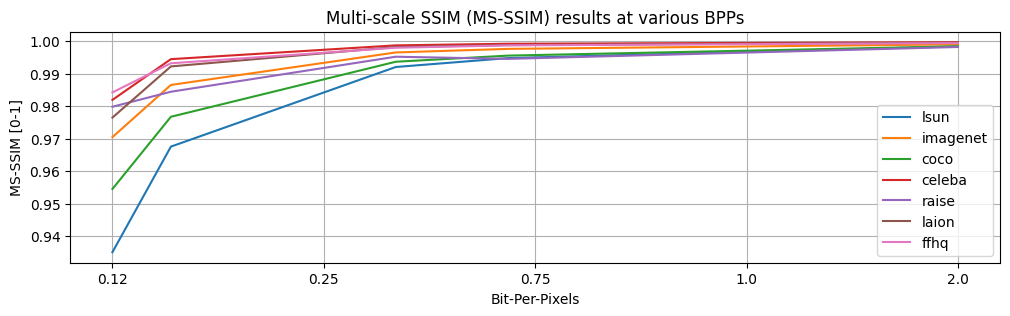

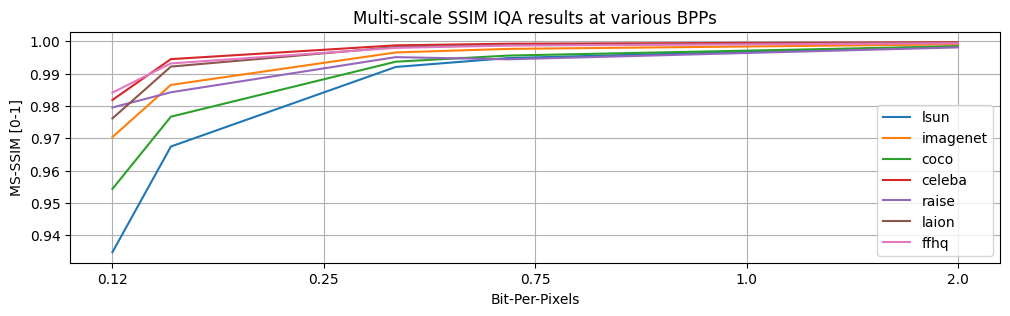

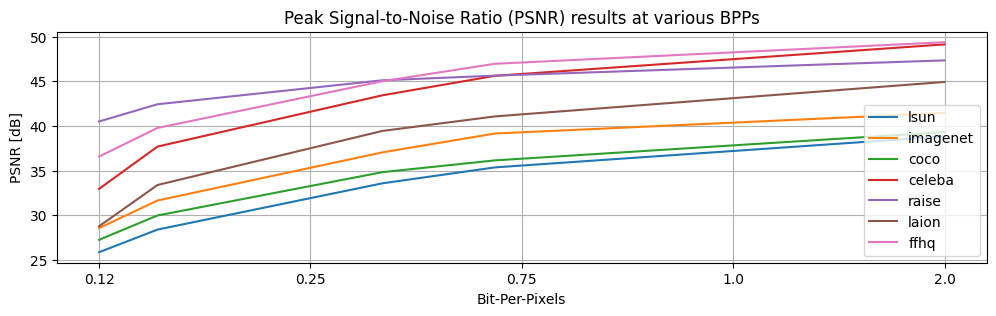

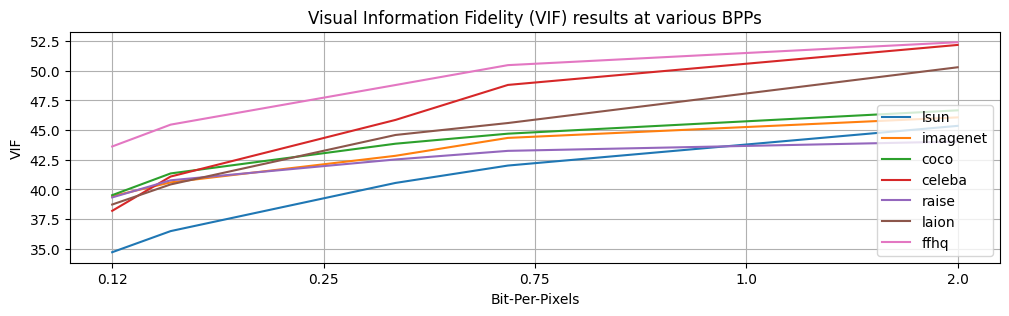

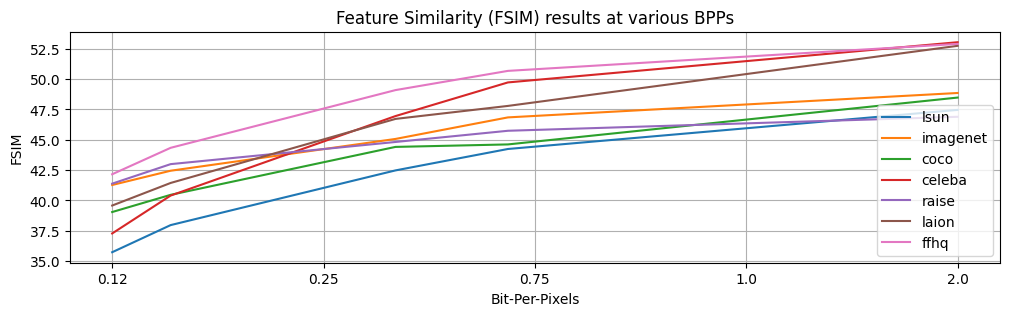

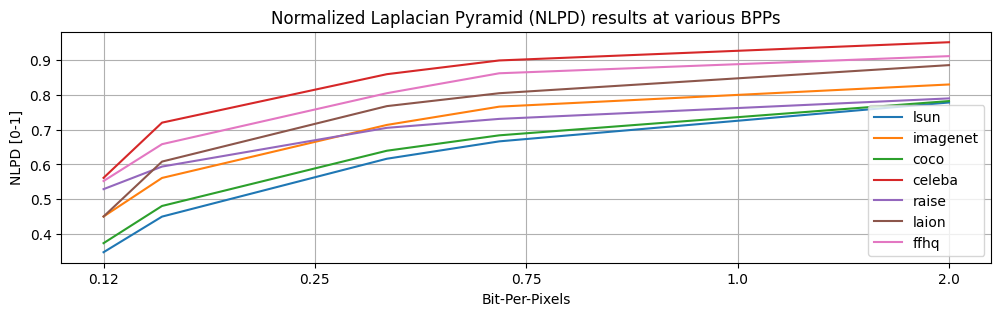

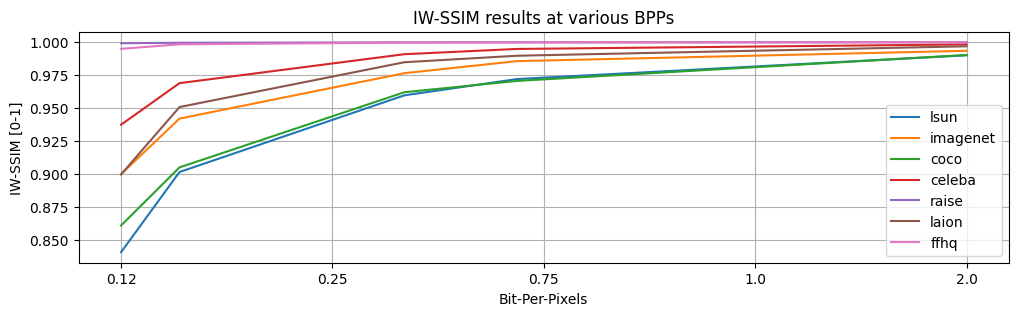

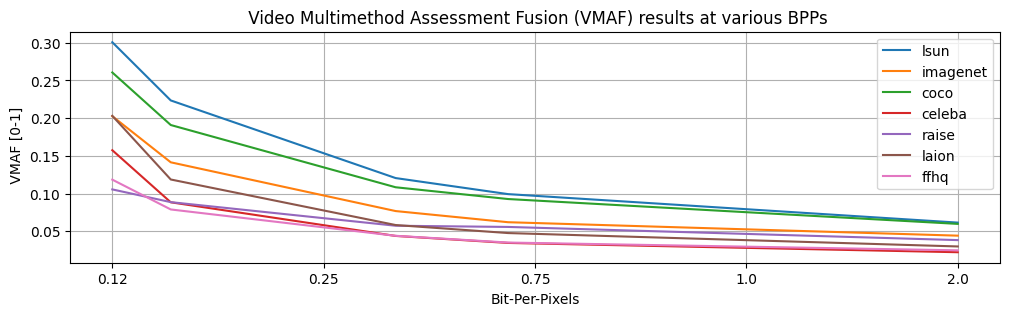

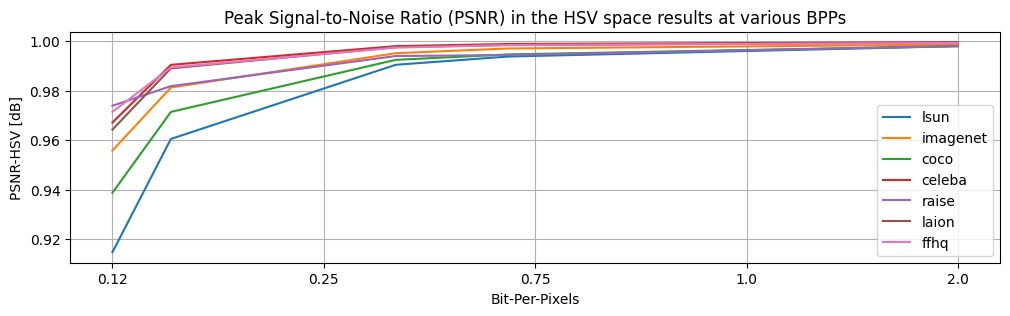

In [61]:
labels_dict = {'msssim_torch': 'Multi-scale SSIM (MS-SSIM)',
  'msssim_iqa': 'Multi-scale SSIM IQA',
  'psnr': 'Peak Signal-to-Noise Ratio (PSNR)',
  'vif': 'Visual Information Fidelity (VIF)',
  'fsim': 'Feature Similarity (FSIM)',
  'nlpd': 'Normalized Laplacian Pyramid (NLPD)',
  'iw-ssim': 'IW-SSIM',
  'vmaf': ' Video Multimethod Assessment Fusion (VMAF)',
  'psnr_hvs': 'Peak Signal-to-Noise Ratio (PSNR) in the HSV space'}

ylabel_dict = {'msssim_torch': 'MS-SSIM [0-1]',
  'msssim_iqa': 'MS-SSIM [0-1]',
  'psnr': 'PSNR [dB]',
  'vif': 'VIF',
  'fsim': 'FSIM',
  'nlpd': 'NLPD [0-1]',
  'iw-ssim': 'IW-SSIM [0-1]',
  'vmaf': ' VMAF [0-1]',
  'psnr_hvs': 'PSNR-HSV [dB]'}

# Let's plot the single metrics
for metric in metrics.metrics_output:
    fig, axs = plt.subplots(1, 1, figsize=(12, 3))
    for dataset in metrics_info.index.get_level_values(0).unique():
        dataset_info = metrics_info.loc[dataset]
        avg_metrics = dataset_info.groupby('bpp').mean()[metric]
        avg_metrics.sort_index(inplace=True)
        axs.plot(avg_metrics, label=dataset)
    plt.legend()
    plt.grid()
    plt.title(f'{labels_dict[metric]} results at various BPPs')
    plt.ylabel(ylabel_dict[metric])
    plt.xticks(ticks=np.linspace(avg_metrics.index[0], avg_metrics.index[-1], len(avg_metrics.index)),
               labels=avg_metrics.index.tolist())
    plt.xlabel('Bit-Per-Pixels')
    plt.show()